In [1]:
# make sure, the numpy library only uses one thread
import os
os.environ["OMP_NUM_THREADS"]="1"

# import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.interpolate

# import models
from earm.lopez_direct import model as md
from earm.lopez_indirect import model as mi
from earm.lopez_embedded import model as me
from pysb.simulator import ScipyOdeSimulator

In [2]:
# load experimental data
exp_data = pd.read_csv('EC-RP_IMS-RP_IC-RP_data_for_models.csv', index_col=False)

# read time points from data file
tspan = exp_data['# Time'].values.copy()

# use the rate parameters that are hardcoded into the model
param_values_i = np.array([p.value for p in mi.parameters])
param_values_d = np.array([p.value for p in md.parameters])
param_values_e = np.array([p.value for p in me.parameters])


# arguments for the model simulation (solve the ODEs)
args = {'integrator': 'lsoda', 'use_analytic_jacobian': True}

# simulate the models
solver_i = ScipyOdeSimulator(mi, tspan, **args)
solver_d = ScipyOdeSimulator(md, tspan, **args)
solver_e = ScipyOdeSimulator(me, tspan, **args)

In [3]:
traj_i = solver_i.run(param_values=param_values_i)
print(exp_data)

     # Time   IC-RP  norm_IC-RP  nrm_var_IC-RP  IMS-RP  IMS-RP step  VAR  \
0       180  0.7063      0.0000         0.0006     0.0          0.0  1.0   
1       360  0.7063      0.0000         0.0006     0.0          0.0  1.0   
2       540  0.7063      0.0000         0.0006     0.0          0.0  1.0   
3       720  0.7063      0.0000         0.0006     0.0          0.0  1.0   
4       900  0.7063      0.0000         0.0006     0.0          0.0  1.0   
5      1080  0.7063      0.0000         0.0006     0.0          0.0  1.0   
6      1260  0.7063      0.0000         0.0006     0.0          0.0  1.0   
7      1440  0.7063      0.0000         0.0006     0.0          0.0  1.0   
8      1620  0.7063      0.0000         0.0006     0.0          0.0  1.0   
9      1800  0.7063      0.0000         0.0006     0.0          0.0  1.0   
10     1980  0.7063      0.0000         0.0006     0.0          0.0  1.0   
11     2160  0.7063      0.0000         0.0006     0.0          0.0  1.0   
12     2340 

In [4]:
print(len(traj_i.observables['mBid']),len(exp_data['norm_IC-RP']))


NameError: name 'traj_i' is not defined

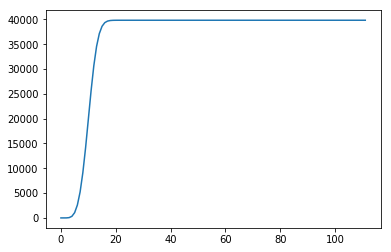

In [20]:
plt.plot(traj_i.observables['mBid'], )

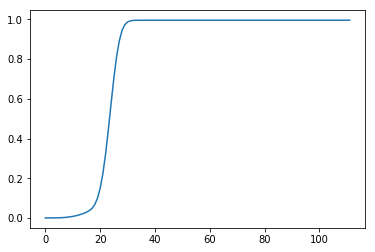

In [27]:
plt.plot(traj_e.observables['mBid'] / me.parameters['Bid_0'].value)

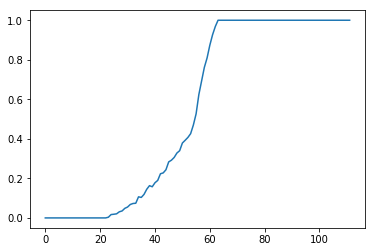

In [26]:
plt.plot(exp_data['norm_IC-RP'])

In [7]:
# save the trajectories of the ODE integration for analysis
traj_i = solver_i.run(param_values=param_values_i)
traj_d = solver_d.run(param_values=param_values_d)
traj_e = solver_e.run(param_values=param_values_e)


# normalize the trajectories to the initial conditions
normal_bid_factor = mi.parameters['Bid_0'].value
normal_smac_factor = mi.parameters['Smac_0'].value
normal_parp_factor = mi.parameters['PARP_0'].value

bid_traj_i = traj_i.observables['mBid'] / normal_bid_factor
bid_traj_d = traj_d.observables['mBid'] / normal_bid_factor
bid_traj_e = traj_e.observables['mBid'] / normal_bid_factor

aSmac_traj_i = traj_i.observables['aSmac'] / normal_smac_factor
aSmac_traj_d = traj_d.observables['aSmac'] / normal_smac_factor
aSmac_traj_e = traj_e.observables['aSmac'] / normal_smac_factor

cparp_traj_i = traj_i.observables['cPARP'] / normal_parp_factor
cparp_traj_d = traj_d.observables['cPARP'] / normal_parp_factor
cparp_traj_e = traj_e.observables['cPARP'] / normal_parp_factor

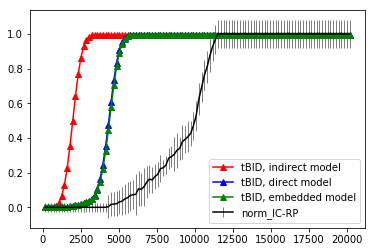

In [4]:
# plot and compare tBid

plt.plot(tspan, bid_traj_i, color='r', marker='^', label='tBID, indirect model')
plt.plot(tspan, bid_traj_d, color='b', marker='^', label='tBID, direct model')
plt.plot(tspan, bid_traj_e, color='g', marker='^', label='tBID, embedded model')
plt.errorbar(exp_data['# Time'], exp_data['norm_IC-RP'],yerr=exp_data['nrm_var_IC-RP'] ** .5,
             ecolor='black', color='black', elinewidth=0.5, capsize=0)
plt.legend(loc=0)

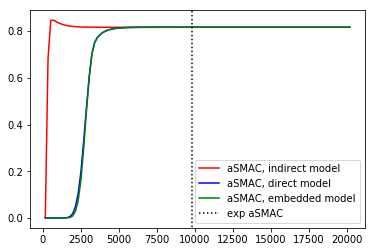

In [5]:
# plot and compare Smac
# the release of Smac is in a Snap action ([Albeck2008])
# this data displays the time in which this snap happens

# Mean and variance of Td (delay time) and Ts (switching time) of MOMP, and
# yfinal (the last value of the IMS-RP trajectory)
momp_data = np.array([9810.0, 180.0, mi.parameters['Smac_0'].value])
momp_var = np.array([7245000.0, 3600.0, 1e4])

plt.plot(tspan, aSmac_traj_i, color='r', label='aSMAC, indirect model')
plt.plot(tspan, aSmac_traj_d, color='b', label='aSMAC, direct model')
plt.plot(tspan, aSmac_traj_e, color='g', label='aSMAC, embedded model')
plt.axvline(momp_data[0], -0.05, 1.05, color='black', linestyle=':',label='exp aSMAC')
plt.legend(loc=0)

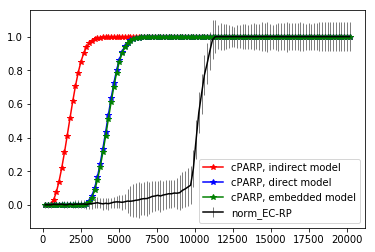

In [6]:
# plot and compare PARP

plt.plot(tspan, cparp_traj_i, color='r', marker='*', label='cPARP, indirect model')
plt.plot(tspan, cparp_traj_d, color='b', marker='*', label='cPARP, direct model')
plt.plot(tspan, cparp_traj_e, color='g', marker='*', label='cPARP, embedded model')
plt.errorbar(exp_data['# Time'], exp_data['norm_EC-RP'],
                 yerr=exp_data['nrm_var_EC-RP'] ** .5,
                 ecolor='black', color='black', elinewidth=0.5, capsize=0)
plt.legend(loc=0)

In [7]:
# define a function which evaluates how far the model is away from the real data
# this cost function is based on the chi^2 test
# this cost function is specifically tailored to EARM

def likelihood(position):
    param_values[rate_mask] = 10 ** position
    traj = solver.run(param_values=param_values)

    model = mi
    # normalize trajectories
    bid_traj = traj.observables['mBid'] / model.parameters['Bid_0'].value
    cparp_traj = traj.observables['cPARP'] / model.parameters['PARP_0'].value
    momp_traj = traj.observables['aSmac']

    # calculate chi^2 distance for each time course
    e1 = np.sum((exp_data['norm_IC-RP'] - bid_traj) ** 2 /
                (2 * exp_data['nrm_var_IC-RP'])) / len(bid_traj)

    e2 = np.sum((exp_data['norm_EC-RP'] - cparp_traj) ** 2 /
                (2 * exp_data['nrm_var_EC-RP'])) / len(cparp_traj)

    # Here we fit a spline to find where we get 50% release of MOMP reporter
    if np.nanmax(momp_traj) == 0:
        print('No aSmac!')
        t10 = 0
        t90 = 0
    else:
        ysim_momp_norm = momp_traj / np.nanmax(momp_traj)
        st, sc, sk = scipy.interpolate.splrep(tspan, ysim_momp_norm)
        try:
            t10 = scipy.interpolate.sproot((st, sc - 0.10, sk))[0]
            t90 = scipy.interpolate.sproot((st, sc - 0.90, sk))[0]
        except IndexError:
            t10 = 0
            t90 = 0

    # time of death  = halfway point between 10 and 90%
    td = (t10 + t90) / 2

    # time of switch is time between 90 and 10 %
    ts = t90 - t10

    # final fraction of aSMAC (last value)
    yfinal = momp_traj[-1]
    momp_sim = [td, ts, yfinal]

    e3 = np.sum((momp_data - momp_sim) ** 2 / (2 * momp_var)) / 3
    # return sum of errors ( the ',' is required)
    return e1 + e2 + e3,

In [8]:
# load simple PSO for the particle swarm optimization
# this method re-evaluates the rate constants
# and tailors them to the real data
from simplepso.pso import PSO

# get the original parameters from the model
rate_params_i = mi.parameters_rules()
rate_params_d = md.parameters_rules()
rate_params_e = me.parameters_rules()

# the parameter set also includes initial conditions 
# those are not to be changed, so this mask filters
# purely the rates from the parameters which need to be trained
rate_mask_i = np.array([p in rate_params_i for p in mi.parameters])
rate_mask_d = np.array([p in rate_params_d for p in md.parameters])
rate_mask_e = np.array([p in rate_params_e for p in me.parameters])

# the original values are used as starting position for the PSO
# PSO searches in log-space for efficiency, therefore, the
# initial data is transformed into log-space
starting_position_i = np.log10(param_values_i[rate_mask_i])
starting_position_d = np.log10(param_values_d[rate_mask_d])
starting_position_e = np.log10(param_values_e[rate_mask_e])

# create a PSO object for the first model
# the parameter values to be trained are the rates from this model
param_values = param_values_i
rate_mask = rate_mask_i
solver = solver_i
pso_i = PSO(save_sampled=False, verbose=True, num_proc=4)
# use the above defined likelihood function as cost-function for the PSO
pso_i.set_cost_function(likelihood)
pso_i.set_start_position(starting_position_i)
pso_i.set_bounds(2)

# run to minimize for the best fit 
# if stopping criteria is reached, run again
pso_i.run(num_particles=25, num_iterations=100, stop_threshold=1e-5)

iteration	best   	avg             	std             	min          	max              
1        	55.1292	[23629.18408795]	[45885.85182874]	[55.12923727]	[154464.79284718]
2        	37.3492	[38226.98216912]	[53240.65036598]	[37.34918388]	[169520.28691027]
3        	37.3492	[38227.0227442] 	[53240.65110395]	[37.34918388]	[169520.28691027]
4        	37.3492	[38230.68179675]	[53240.72070434]	[37.34918388]	[169520.28691027]
5        	37.3492	[38230.68179675]	[53240.72070434]	[37.34918388]	[169520.28691027]
6        	37.3492	[38230.68179675]	[53240.72070434]	[37.34918388]	[169520.28691027]
7        	37.3492	[38230.68179675]	[53240.72070434]	[37.34918388]	[169520.28691027]
8        	37.3492	[38227.01065748]	[53240.65117235]	[37.34918388]	[169520.28691027]
9        	37.3492	[38227.03181996]	[53240.63534022]	[37.34918388]	[169520.28691027]
10       	37.3492	[38228.06754132]	[53240.65264277]	[37.34918388]	[169520.28691027]
11       	37.3492	[38230.70774902]	[53240.70362352]	[37.34918388]	[169520.28

In [9]:
# new rate parameters for the indirect model
display(pso_i.best)

# run indirect model with newly suggested rates
# results of PSO are in log-space -> retransform into normal space
param_values[rate_mask] = 10 ** pso_i.best

# save the new parameters for later use in an external csv file
np.savetxt("fitted_model_i_parameters.csv", param_values)

# run the indirect model with the new rate parameters
traj_i = solver_i.run(param_values=param_values)

# normalize the results again
bid_traj_i = traj_i.observables['mBid'] / normal_bid_factor
cparp_traj_i = traj_i.observables['cPARP'] / normal_parp_factor
aSmac_traj_i = traj_i.observables['aSmac'] / normal_smac_factor

Particle([-8.39794001, -4.44175585, -6.20118278, -4.        , -5.        ,
           2.        , -6.48471934, -1.        ,  1.04550892, -4.        ,
          -1.50822631, -7.99442729, -4.89313584,  0.        , -3.60741657,
           0.        , -3.95706077, -4.48365026, -4.96844789, -2.        ,
          -9.30103   , -1.66201103, -6.55587746, -1.00314219, -2.        ,
          -6.00620518, -1.        , -3.16388571, -2.49177267, -5.        ,
          -1.00320058,  1.89835709, -7.69897   , -1.        , -3.        ,
          -5.90254966, -4.        , -2.        , -8.        , -4.75200092,
          -1.27590641, -5.60018828, -4.94550013, -2.        ,  0.50366395,
          -5.        , -4.        , -4.        , -0.52627892, -4.        ,
          -3.56799151, -4.        , -3.99821534, -0.29172547, -8.        ,
          -1.11115584, -4.        ,  0.07918125, -4.        , -0.27253672,
          -8.        ,  0.        , -8.        , -1.9778135 , -5.13012948,
          -2.49311415, -6

In [10]:
# do PSO for the direct model

param_values = param_values_d
rate_mask = rate_mask_d
solver = solver_d
pso_d = PSO(save_sampled=False, verbose=True, num_proc=4)
pso_d.set_cost_function(likelihood)
pso_d.set_start_position(starting_position_d)
pso_d.set_bounds(2)

pso_d.run(num_particles=25, num_iterations=100, stop_threshold=1e-5)

iteration	best   	avg             	std             	min          	max              
1        	53.0135	[67494.91370274]	[67941.82340755]	[53.01351234]	[166466.79308864]
No aSmac!
2        	25.8119	[114548.29961592]	[74212.02014932]	[25.81193701]	[174309.44088048]
No aSmac!
3        	25.8119	[114548.12002818]	[74211.88398422]	[25.81193701]	[174309.44088048]
No aSmac!
4        	25.8119	[109300.69730748]	[76263.2773964] 	[25.81193701]	[174309.44088048]
No aSmac!
5        	25.8119	[109302.27377862]	[76261.36809607]	[25.81193701]	[174309.44088048]
No aSmac!
6        	25.8119	[109558.76290622]	[75960.5464285] 	[25.81193701]	[174309.44088048]
No aSmac!
7        	25.8119	[113778.54142987]	[73959.24226689]	[25.81193701]	[174309.44088048]
No aSmac!
8        	25.8119	[109300.69496255]	[76263.28334377]	[25.81193701]	[174309.44088048]
No aSmac!
9        	25.8119	[109300.55706521]	[76263.45038949]	[25.81193701]	[174309.44088048]
No aSmac!
10       	25.8119	[113938.24119169]	[73977.69944292]	[25.81193

95       	3.5568 	[3.57739975]     	[0.02172645]    	[3.55679973] 	[3.66612864]     
96       	3.5568 	[3.5753293]      	[0.01991551]    	[3.55679901] 	[3.65795191]     
97       	3.5568 	[3.57425679]     	[0.01940333]    	[3.55679897] 	[3.65575098]     
98       	3.5568 	[3.57352404]     	[0.01905084]    	[3.55679898] 	[3.65482232]     
99       	3.5568 	[3.57291394]     	[0.01896878]    	[3.55679897] 	[3.65450174]     
100      	3.5568 	[3.57239452]     	[0.0180798]     	[3.55679898] 	[3.64950909]     


In [12]:
#run direct model with newly suggested rates
param_values[rate_mask] = 10 ** pso_d.best
np.savetxt("fitted_model_d_parameters.csv", param_values)
traj_d = solver_d.run(param_values=param_values)

bid_traj_d = traj_d.observables['mBid'] / normal_bid_factor
cparp_traj_d = traj_d.observables['cPARP'] / normal_parp_factor
aSmac_traj_d = traj_d.observables['aSmac'] / normal_smac_factor

In [24]:
# do PSO for the embedded model

param_values = param_values_e
rate_mask = rate_mask_e
solver = solver_e
pso_e = PSO(save_sampled=False, verbose=True, num_proc=4)
pso_e.set_cost_function(likelihood)
pso_e.set_start_position(starting_position_e)
pso_e.set_bounds(2)

pso_e.run(num_particles=25, num_iterations=100, stop_threshold=1e-5)

iteration	best   	avg            	std             	min          	max              
1        	19.7998	[39173.5630225]	[65721.21920538]	[19.79982777]	[169277.78135793]
2        	19.7998	[89977.72472463]	[76492.79002061]	[57.33162935]	[172520.42099763]
3        	19.7998	[89977.72472463]	[76492.79002061]	[57.33162935]	[172520.42099763]
4        	19.7998	[89977.72472463]	[76492.79002061]	[57.33162935]	[172520.42099763]
5        	19.7998	[89977.70746086]	[76492.80715428]	[57.33162935]	[172520.42099763]
6        	19.7998	[89977.70745098]	[76492.80714612]	[57.33162935]	[172520.42099763]
7        	19.7998	[89977.59966711]	[76492.72163396]	[57.33162935]	[172520.42099763]
8        	19.7998	[89977.31389924]	[76492.47617651]	[57.33162935]	[172520.42099763]
9        	19.7998	[89988.12331415]	[76503.33265048]	[57.33162935]	[172520.42099763]
10       	19.7998	[89988.09818351]	[76503.32131885]	[56.63796078]	[172520.42099763]
11       	19.7998	[89988.16399228]	[76503.34824596]	[56.98242732]	[172520.4209

97       	0.515189	[0.59458194]    	[0.09460392]    	[0.51521036] 	[0.798258]       
98       	0.515189	[0.5879606]     	[0.09677217]    	[0.51520818] 	[0.80166416]     
99       	0.515189	[0.58609615]    	[0.09269625]    	[0.51520599] 	[0.80195423]     
100      	0.515189	[0.58291163]    	[0.08931896]    	[0.51520523] 	[0.78586696]     


In [25]:
# run embedded model with newly suggested rates
param_values[rate_mask] = 10 ** pso_e.best
np.savetxt("fitted_model_e_parameters.csv", param_values)
traj_e = solver_e.run(param_values=param_values)

bid_traj_e = traj_e.observables['mBid'] / normal_bid_factor
cparp_traj_e = traj_e.observables['cPARP'] / normal_parp_factor
aSmac_traj_e = traj_e.observables['aSmac'] / normal_smac_factor

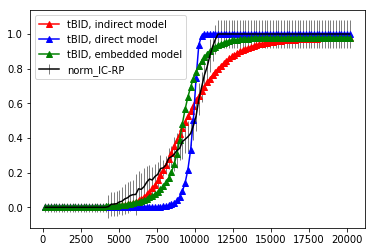

In [26]:
# compare the models using the new rates with the experimental data

plt.plot(tspan, bid_traj_i, color='r', marker='^', label='tBID, indirect model')
plt.plot(tspan, bid_traj_d, color='b', marker='^', label='tBID, direct model')
plt.plot(tspan, bid_traj_e, color='g', marker='^', label='tBID, embedded model')
plt.errorbar(exp_data['# Time'], exp_data['norm_IC-RP'],
                 yerr=exp_data['nrm_var_IC-RP'] ** .5,
                 ecolor='black', color='black', elinewidth=0.5, capsize=0)
plt.legend(loc=0)

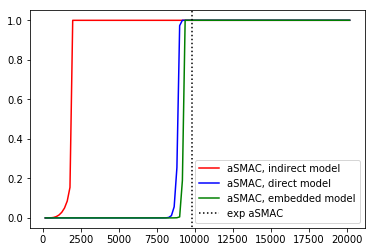

In [29]:
plt.plot(tspan, aSmac_traj_i, color='r', label='aSMAC, indirect model')
plt.plot(tspan, aSmac_traj_d, color='b', label='aSMAC, direct model')
plt.plot(tspan, aSmac_traj_e, color='g', label='aSMAC, embedded model')
plt.axvline(momp_data[0], -0.05, 1.05, color='black', linestyle=':',
               label='exp aSMAC')
plt.legend(loc=0)

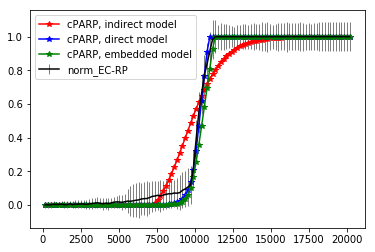

In [28]:
plt.plot(tspan, cparp_traj_i, color='r', marker='*', label='cPARP, indirect model')
plt.plot(tspan, cparp_traj_d, color='b', marker='*', label='cPARP, direct model')
plt.plot(tspan, cparp_traj_e, color='g', marker='*', label='cPARP, embedded model')
plt.errorbar(exp_data['# Time'], exp_data['norm_EC-RP'],
                 yerr=exp_data['nrm_var_EC-RP'] ** .5,
                 ecolor='black', color='black', elinewidth=0.5, capsize=0)
plt.legend(loc=0)